Moscow flats dataset, I will compare the accuracy of prediction of linear regression and of random forest

In [1]:
# load necessary libraries
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.regression.linear_model import OLS
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error as mape, r2_score as r2
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# download data
df = pd.read_csv(r"C:\Users\shuva\Downloads\df\df\flats_moscow.csv")
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2040 non-null   int64  
 1   price       2040 non-null   int64  
 2   totsp       2040 non-null   int64  
 3   livesp      2040 non-null   int64  
 4   kitsp       2040 non-null   float64
 5   dist        2040 non-null   float64
 6   metrdist    2040 non-null   int64  
 7   walk        2040 non-null   int64  
 8   brick       2040 non-null   int64  
 9   floor       2040 non-null   int64  
 10  code        2040 non-null   int64  
dtypes: float64(2), int64(9)
memory usage: 175.4 KB


,Unnamed: 0,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
count,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000
mean,1020.500000,127.496569,73.084314,46.337255,8.898529,11.015686,8.117157,0.685784,0.323039,0.790686,4.322059
std,589.041594,51.878220,15.123450,7.894348,2.787073,3.375539,3.815574,0.464317,0.467752,0.406918,2.183289
min,1.000000,50.000000,44.000000,28.000000,5.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,510.750000,95.000000,62.000000,42.000000,7.000000,9.000000,5.000000,0.000000,0.000000,1.000000,3.000000
50%,1020.500000,115.000000,73.500000,45.000000,9.000000,12.000000,7.000000,1.000000,0.000000,1.000000,4.000000
75%,1530.250000,142.000000,79.000000,50.000000,10.000000,13.500000,10.000000,1.000000,1.000000,1.000000,6.000000
max,2040.000000,730.000000,192.000000,102.000000,25.000000,17.000000,20.000000,1.000000,1.000000,1.000000,8.000000


There are no nans; 
Price - price of the flat in thousand US Dollars, totsp - square of flat in sq meters, livesp - living space in sq meters, kitsp - kitchen space in sq meters, dist - distance to city center in km, metrdist - distance to nearest metro station in min, walk - can we walk to metro? 1 or 0 , brick - 0 or 1, floor - 1 (if not the first of the last) or 0 - otherwise.

In [3]:
# drop unnecessary column
df = df.drop(columns='Unnamed: 0')

In [4]:
# divide data into test and train sample
train = df.sample(frac=0.8, random_state=0)
test = df.drop(train.index)

In [5]:
# let's look at linear correlations between variables
round(train.corr(),2)

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
price,1.00,0.76,0.73,0.60,-0.33,-0.14,0.14,0.25,0.14,-0.09
totsp,0.76,1.00,0.87,0.79,-0.12,-0.03,0.02,0.10,0.12,-0.03
livesp,0.73,0.87,1.00,0.58,-0.20,-0.04,0.06,0.24,0.10,-0.01
kitsp,0.60,0.79,0.58,1.00,-0.07,-0.01,-0.00,-0.04,0.12,-0.05
dist,-0.33,-0.12,-0.20,-0.07,1.00,0.11,-0.17,-0.39,0.02,-0.19
metrdist,-0.14,-0.03,-0.04,-0.01,0.11,1.00,-0.03,-0.06,-0.02,-0.01
walk,0.14,0.02,0.06,-0.00,-0.17,-0.03,1.00,0.15,-0.03,-0.03
brick,0.25,0.10,0.24,-0.04,-0.39,-0.06,0.15,1.00,-0.04,0.03
floor,0.14,0.12,0.10,0.12,0.02,-0.02,-0.03,-0.04,1.00,-0.06
code,-0.09,-0.03,-0.01,-0.05,-0.19,-0.01,-0.03,0.03,-0.06,1.00


There are strong correlations between price and totsp and price livesp  
Let's build scatter plots

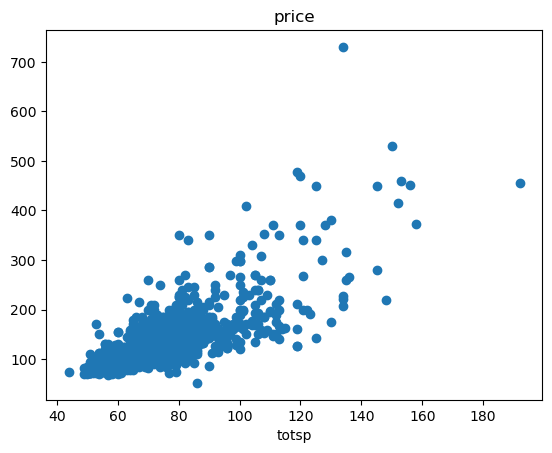

In [6]:
# scatter plot, totsp - blue
plt.scatter(x=train.totsp, y=train.price)
plt.title("price")
plt.xlabel("totsp")
plt.show()

We better use natural log of price, and that of totsp and of livesp

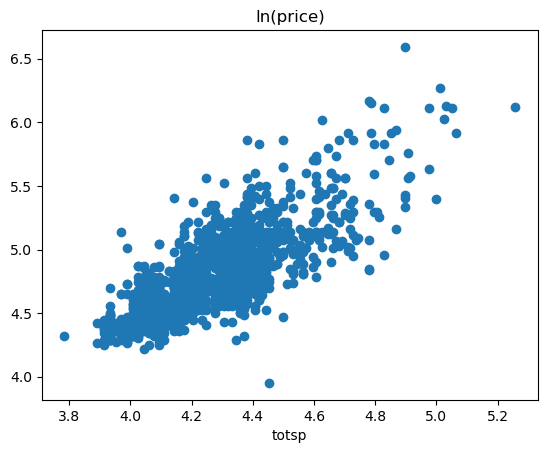

In [7]:
# scatter plot, totsp - blue, livesp - orange
# it looks much better than previous one
plt.scatter(x=np.log(train.totsp), y=np.log(train.price))
plt.title("ln(price)")
plt.xlabel("totsp")
plt.show()

I will use log(price) in upcoming modeling

In [8]:
# divide data into dependent and independent variables
y = np.log(train.loc[:,'price']).copy()
x = train.loc[:,df.columns != 'price'].copy()
x_test = test.loc[:,df.columns != 'price'].copy()
y_test = test.loc[:,'price'].copy()

In [9]:
# log manipulations with data
x['totsp'] = np.log(x['totsp'])
x['livesp'] = np.log(x['livesp'])
x_test['totsp'] = np.log(x_test['totsp'])
x_test['livesp'] = np.log(x_test['livesp'])

In [10]:
# Instantiate model with 100 decision trees
rf = RandomForestRegressor(random_state = 42)

In [11]:
# Train the model on training data
rf.fit(x, y)

RandomForestRegressor(random_state=42)

In [12]:
# predict on test sample
predict_rf = np.exp(rf.predict(x_test))

In [13]:
# regression model
x = sm.add_constant(x) # no need for constant since it's not significant
regr = OLS(y,x).fit()
print(regr.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     533.0
Date:                Fri, 10 Nov 2023   Prob (F-statistic):               0.00
Time:                        17:18:38   Log-Likelihood:                 674.59
No. Observations:                1632   AIC:                            -1329.
Df Residuals:                    1622   BIC:                            -1275.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4138      0.135      3.056      0.0

In [14]:
## Checking for multicollinarity
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = x.drop(columns='const').columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x.drop(columns='const').values, i)
                          for i in range(len(x.drop(columns='const').columns))]
  
print(vif_data)

    feature          VIF
0     totsp  2833.431148
1    livesp  2568.126562
2     kitsp    19.797861
3      dist    14.400553
4  metrdist     5.581570
5      walk     3.439190
6     brick     1.871179
7     floor     4.974420
8      code     5.128714


Regularization, since we do have a strong multicollinearity

In [15]:
regul = OLS(y,x).fit_regularized(alpha=0)
regul.params

const       4.562726
totsp       0.058863
livesp     -0.007083
kitsp       0.061769
dist       -0.034360
metrdist   -0.011773
walk        0.028376
brick       0.084469
floor       0.025387
code       -0.029964
dtype: float64

In [16]:
# regression prediction
x_test = sm.add_constant(x_test)
predict_regr = np.exp(regul.predict(x_test))

In [17]:
# calculate errors
print('regression prediction error: ', mape(y_test, predict_regr))
print('random forest prediction error: ', mape(y_test, predict_rf))

regression prediction error:  0.1510270811750826
random forest prediction error:  0.09663623344995835


Random forest prediction shows more accuracy than that of regression, however both metrics are lower than 16%, thus both models can be applied, but random forest are generally better than regression in this particular case